## The ultimate goal here is to start trying to characterize various regimes around the globe in terms of the relationships between mean wind speed and wind variance near the surface, as well as surface fluxes and PBL height vs. mean wind speed. 
<br>
This was originally part of the script Regional_CombineUV.ipynb, but it makes more sense to keep it seperate. <br>
<br>
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 21 Oct 2020 <br>

In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib as matplotlib
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats


## 1. Read in and process data 

This is meant to run with output from AMIP simulations. Note that there are a *ton* of different file naming conventions here. This could certainly be streamlined, but is written this way due to incremental accesasing of new data from the same simulation. I've used NCO to concatenate certain variables into individual files over a certain decade.<br>
(E.g., <i>ncrcat -v SHFLX,LHFLX f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.197* f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.1970-1979_sfcFluxes.nc</i>)

In [2]:
# Set up directories 
dataDir    = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/'
nameStart  = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd    = '_CLUBBwinds.nc'
nameEnd_UV = '_UV.nc'
nameEnd_W  = '_W.nc'
nameEnd_PBLH = '_PBLH.nc'
nameEnd_FLX  = '_sfcFluxes.nc'

#decadeList = ['1951-59','1960-69', '1970-79','1980-89','1990-99','2000-14']
decadeList = ['1970-79','1980-89','1990-99','2000-14']

<ipython-input-57-fc907abc9c0b>:16: RuntimeWarning: invalid value encountered in less
  iceMask[iceContent<10000] = 1


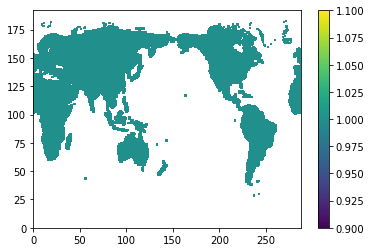

In [57]:
# Read in single history file to get lat/lon and masks 
testName = dataDir+'f.e20.FHIST.f09_f09.cesm2_1.001.clm2.h0.1989-12.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landMask              = testDF.landmask.values
landMask[landMask==0] = np.nan

# Ideally, want to mask out Greenland/Antarctica too (ice sheets)
iceContent = testDF.ICE_CONTENT1.values[0,:,:]  # "Initial gridcell total ice content"
iceMask    = np.full([len(lat),len(lon)], np.nan)
iceMask[iceContent<10000] = 1


Since files are saved by decade, it's easy to read them all in by decade as well. They're read in as xarray datasets and then concatenated into one large dataset with xr.concat along the time dimension. The dates are then reformatted to correspond to a pandas datetimeindex, which is *much* easier to work with (i.e., you can easily index to get year, month, etc). 

In [4]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    fileName = dataDir+nameStart+decadeList[iDec]+nameEnd
    dataDF   = xr.open_dataset(fileName, decode_times=True)
    dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    UVfile = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
    windDF = xr.open_dataset(UVfile, decode_times=True)
    windDF['time'] = windDF.indexes['time'].to_datetimeindex()
    
#     Wfile = dataDir+nameStart+decadeList[iDec]+nameEnd_W
#     vertDF = xr.open_dataset(Wfile, decode_times=True)
#     vertDF['time'] = vertDF.indexes['time'].to_datetimeindex()
    
#     PSfile = dataDir+nameStart+decadeList[iDec]+'_PS.nc'
#     presDF = xr.open_dataset(PSfile, decode_times=True)
#     presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    PBLHfile = dataDir+nameStart+decadeList[iDec]+nameEnd_PBLH
    pblhDF   = xr.open_dataset(PBLHfile, decode_times=True)
    pblhDF['time'] = pblhDF.indexes['time'].to_datetimeindex()
    
    FLXfile = dataDir+nameStart+decadeList[iDec]+nameEnd_FLX
    flxDF   = xr.open_dataset(FLXfile, decode_times=True)
    flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullDF = dataDF
        fullUV = windDF
        fullPBLH = pblhDF
        fullFLX  = flxDF
#         fullW  = vertDF
#         fullPS = presDF
    else:
        fullDF = xr.concat([fullDF, dataDF], dim="time")
        fullUV = xr.concat([fullUV, windDF], dim="time")
        fullPBLH = xr.concat([fullPBLH, pblhDF], dim="time")
        fullFLX  = xr.concat([fullFLX, flxDF], dim="time")
#         fullW  = xr.concat([fullW,  vertDF], dim="time")
#         fullPS = xr.concat([fullPS, presDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullDF['time']))

<ipython-input-4-a5b5b58f2600>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-4-a5b5b58f2600>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  windDF['time'] = windDF.indexes['time'].to_datetimeindex()
<ipython-input-4-a5b5b58f2600>:23: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors i

Done with decade  1970-79  ... 
    Number of times saved:  120
Done with decade  1980-89  ... 
    Number of times saved:  240
Done with decade  1990-99  ... 
    Number of times saved:  360
Done with decade  2000-14  ... 
    Number of times saved:  540


In [5]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullDF['time'].values) 

# Let's set the monthly averages to be roughly mid-month
#   This way, the average for January has a month of 1 instead of being the first day of February 
midTime = dates - timedelta(days=15)       # Get new dates array that has the right month/year in it 


Model levels are stored with the *top* level as index 0. So to make life a bit easier, I like to flip those arrays around so that the first index is the level closest to the surface. It's also a bit easier (though less efficient) to pull out the arrays of values I'll be working with later into a single unique variable. 

In [6]:
# Read into individual arrays for easy access

UP2 = fullDF.UP2_CLUBB.values      # Zonal velocity variance (m2/s2)
VP2 = fullDF.VP2_CLUBB.values      # Meridional velocity variance (m2/s2)
WP2 = fullDF.WP2_CLUBB.values      # Vertical velocity variance (m2/s2)
WP3 = fullDF.WP3_CLUBB.values      # Third moment vertical velocity (m3/s3)
PBLH = fullPBLH.PBLH.values
SHFLX = fullFLX.SHFLX.values
LHFLX = fullFLX.LHFLX.values

U   = fullUV.U.values              # Zonal wind (m/s)
V   = fullUV.V.values              # Meridional wind (m/s)
#W   = fullW.W.values              # Vertical velocity (m/s) -- script to compute on /glade/work/mdfowler/...


In [7]:
# Flip along vertical (level) axis, so that index 0 is surface 

UP2 = np.flip(UP2, axis=1)
VP2 = np.flip(VP2, axis=1)
WP2 = np.flip(WP2, axis=1)
WP3 = np.flip(WP3, axis=1)

U   = np.flip(U, axis=1)
V   = np.flip(V, axis=1)
#W   = np.flip(W, axis=1)

# Save levels themselves to arrays and flip them 
lev_interface = np.flip(fullDF.ilev.values)
lev_middle    = np.flip(fullUV.lev.values)


We found some odd looking artifacts when using *just* zonal winds (U) near the surface for understanding the relationship between mean wind and wind variance. So instead, let's use total wind speed and total wind variance - that is, sqrt(u^2 + v^2) for wind speed, and the sum of the meridional and zonal wind variances for total wind variance. 

In [8]:
# Now get surface wind magnitude and combine variances 
windSpd = np.sqrt(U**2 + V**2)
windVar = UP2 + VP2 


Lastly for this section, we'll want to pay close attention to certain seasons for a lot of this analysis, and we mostly care about near-surface winds. So let's pick out the indices corresponding to those months and those levels. 

In [9]:
# Get seasonal indices 
iDJF = np.where((midTime.month==12) | (midTime.month<=2))[0]
iMAM = np.where((midTime.month>=3)  & (midTime.month<=5))[0]
iJJA = np.where((midTime.month>=6)  & (midTime.month<=8))[0]
iSON = np.where((midTime.month>=9)  & (midTime.month<=11))[0]

# Select near surface speed and variance 
sfcWindSpd = windSpd[:,0,:,:]
sfcWindVar = windVar[:,1,:,:]


## 2. Carry out linear regression on sets of variables that could be interesting 

Writing up a very simple function to return stats from linear regression over a 3D array with dimensions of [time, lat, lon]

In [14]:
def linRegress3D(xVar, yVar):
    
    # Get length of lat/lon dimensions 
    shapeDat = np.shape(xVar)
    nlat     = shapeDat[1]
    nlon     = shapeDat[2]
    
    # Define empty arrays to return 
    slope     = np.full([nlat, nlon], np.nan)
    intercept = np.full([nlat, nlon], np.nan)
    rValue    = np.full([nlat, nlon], np.nan)
    pValue    = np.full([nlat, nlon], np.nan)
    
    for ilat in range(len(lat)):
        for ilon in range(len(lon)): 
            x = xVar[:,ilat,ilon]
            y = yVar[:,ilat,ilon]

            # Perform linear regression
            slope[ilat,ilon], intercept[ilat,ilon], rValue[ilat,ilon], pValue[ilat,ilon], std_err = stats.linregress(x, y)


    return(slope,intercept,rValue,pValue)


First, lets look just at JJA. Also, let's say we're only interested in land points for right now and classifying those. 

In [58]:
# Use only land points... (and exclude ice sheets)
sfcWindSpd_land = sfcWindSpd*landMask*iceMask
sfcWindVar_land = sfcWindVar*landMask*iceMask
PBLH_land       = PBLH*landMask*iceMask
SHFLX_land      = SHFLX*landMask*iceMask
LHFLX_land      = LHFLX*landMask*iceMask

# Also consider using the bowen ratio or EF rather than fluxes individually (more holistic energy concept)
EF_land         = LHFLX_land / (LHFLX_land + SHFLX_land)
bowen_land      = SHFLX_land / LHFLX_land


In [59]:
# Now pick out JJA values: 
sfcWindSpd_JJA = sfcWindSpd_land[iJJA,:,:]
sfcWindVar_JJA = sfcWindVar_land[iJJA,:,:]
PBLH_JJA       = PBLH_land[iJJA,:,:]
SHFLX_JJA      = SHFLX_land[iJJA,:,:]
LHFLX_JJA      = LHFLX_land[iJJA,:,:]
EF_JJA         = EF_land[iJJA,:,:]
bowen_JJA      = bowen_land[iJJA,:,:]


Now perform the linear regression and save statistics out 

In [126]:
# Linear regression between wind speed and wind variance (surface)
slope_SpdVar_JJA,intercept_SpdVar_JJA,rValue_SpdVar_JJA,pValue_SpdVar_JJA = linRegress3D(sfcWindSpd_JJA, sfcWindVar_JJA)
print('...Regression between wind speed and variance completed...')

# Linear regression between mean wind speed and PBLH 
slope_SpdPBL_JJA,intercept_SpdPBL_JJA,rValue_SpdPBL_JJA,pValue_SpdPBL_JJA = linRegress3D(sfcWindSpd_JJA, PBLH_JJA)

# Linear regression between wind variance and PBLH 
slope_VarPBL_JJA,intercept_VarPBL_JJA,rValue_VarPBL_JJA,pValue_VarPBL_JJA = linRegress3D(sfcWindVar_JJA, PBLH_JJA)
print('...Regression between wind speed/var and PBLH completed...')

# Linear regression between mean wind speed and SHFLX 
slope_SpdSHF_JJA,intercept_SpdSHF_JJA,rValue_SpdSHF_JJA,pValue_SpdSHF_JJA = linRegress3D(sfcWindSpd_JJA, np.abs(SHFLX_JJA))

# Linear regression between mean wind speed and LHFLX
slope_SpdLHF_JJA,intercept_SpdLHF_JJA,rValue_SpdLHF_JJA,pValue_SpdLHF_JJA = linRegress3D(sfcWindSpd_JJA, np.abs(LHFLX_JJA))
print('...Regression between wind speed and surface fluxes completed...')

# Linear regression between mean wind speed and evaporative fraction 
slope_SpdEF_JJA,intercept_SpdEF_JJA,rValue_SpdEF_JJA,pValue_SpdEF_JJA = linRegress3D(sfcWindSpd_JJA, EF_JJA)

# Linear regresion between mean wind speed and bowen ratio 
slope_SpdBowen_JJA,intercept_SpdBowen_JJA,rValue_SpdBowen_JJA,pValue_SpdBowen_JJA = linRegress3D(sfcWindSpd_JJA, bowen_JJA)
print('...Regression between wind speed and EF/Bowen ratio completed...')


...Regression between wind speed and variance completed...
...Regression between wind speed/var and PBLH completed...
...Regression between wind speed and surface fluxes completed...
...Regression between wind speed and EF/Bowen ratio completed...


## 3. Map out where regression slopes are high vs. low 

Reshape regression slopes to be 1D - quicker to plot histograms and get percentiles this way. 

In [127]:
slope_SpdVar_1d   = slope_SpdVar_JJA.reshape(len(lat)*len(lon))
slope_SpdPBL_1d   = slope_SpdPBL_JJA.reshape(len(lat)*len(lon))
slope_VarPBL_1d   = slope_VarPBL_JJA.reshape(len(lat)*len(lon))
slope_SpdSHF_1d   = slope_SpdSHF_JJA.reshape(len(lat)*len(lon))
slope_SpdLHF_1d   = slope_SpdLHF_JJA.reshape(len(lat)*len(lon))
slope_SpdEF_1d    = slope_SpdEF_JJA.reshape(len(lat)*len(lon))
slope_SpdBowen_1d = slope_SpdBowen_JJA.reshape(len(lat)*len(lon))


Compute 25th and 75th percentiles of slopes (using absolute values) 

In [132]:
pct25_SpdVar = np.nanpercentile(np.abs(slope_SpdVar_1d), 25)
pct75_SpdVar = np.nanpercentile(np.abs(slope_SpdVar_1d), 75)

pct25_SpdPBL = np.nanpercentile(np.abs(slope_SpdPBL_1d), 25)
pct75_SpdPBL = np.nanpercentile(np.abs(slope_SpdPBL_1d), 75)

pct25_VarPBL = np.nanpercentile(np.abs(slope_VarPBL_1d), 25)
pct75_VarPBL = np.nanpercentile(np.abs(slope_VarPBL_1d), 75)

pct25_SpdSHF = np.nanpercentile(np.abs(slope_SpdSHF_1d), 25)
pct75_SpdSHF = np.nanpercentile(np.abs(slope_SpdSHF_1d), 75)

pct25_SpdLHF = np.nanpercentile(np.abs(slope_SpdLHF_1d), 25)
pct75_SpdLHF = np.nanpercentile(np.abs(slope_SpdLHF_1d), 75)

pct25_SpdEF = np.nanpercentile(np.abs(slope_SpdEF_1d), 25)
pct75_SpdEF = np.nanpercentile(np.abs(slope_SpdEF_1d), 75)

pct25_SpdBowen = np.nanpercentile(np.abs(slope_SpdBowen_1d), 25)
pct75_SpdBowen = np.nanpercentile(np.abs(slope_SpdBowen_1d), 75)


Plot histograms of slopes with 75th and 25th percentiles

In [149]:
np.linspace(np.nanpercentile(np.abs(slope_SpdVar_1d), 5), 
                       np.nanpercentile(np.abs(slope_SpdVar_1d), 95), 75)

array([0.00502397, 0.00695025, 0.00887654, 0.01080282, 0.01272911,
       0.01465539, 0.01658168, 0.01850796, 0.02043425, 0.02236053,
       0.02428682, 0.0262131 , 0.02813938, 0.03006567, 0.03199195,
       0.03391824, 0.03584452, 0.03777081, 0.03969709, 0.04162338,
       0.04354966, 0.04547595, 0.04740223, 0.04932851, 0.0512548 ,
       0.05318108, 0.05510737, 0.05703365, 0.05895994, 0.06088622,
       0.06281251, 0.06473879, 0.06666508, 0.06859136, 0.07051765,
       0.07244393, 0.07437021, 0.0762965 , 0.07822278, 0.08014907,
       0.08207535, 0.08400164, 0.08592792, 0.08785421, 0.08978049,
       0.09170678, 0.09363306, 0.09555934, 0.09748563, 0.09941191,
       0.1013382 , 0.10326448, 0.10519077, 0.10711705, 0.10904334,
       0.11096962, 0.11289591, 0.11482219, 0.11674847, 0.11867476,
       0.12060104, 0.12252733, 0.12445361, 0.1263799 , 0.12830618,
       0.13023247, 0.13215875, 0.13408504, 0.13601132, 0.13793761,
       0.13986389, 0.14179017, 0.14371646, 0.14564274, 0.14756

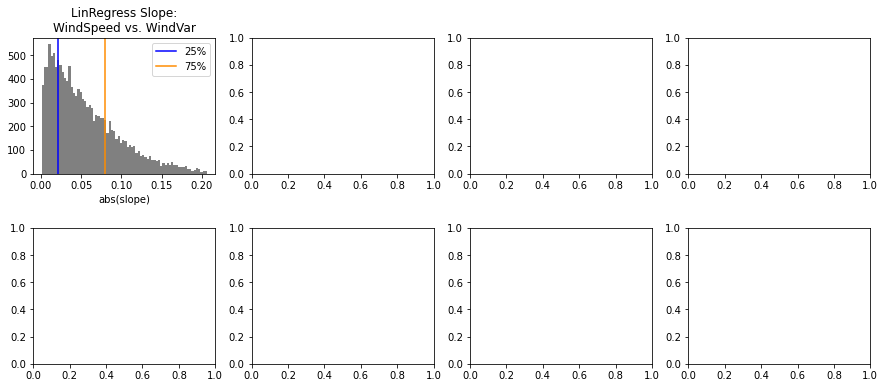

In [165]:
fig, axs = plt.subplots(2,4, figsize=(15, 6))
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.2)

# ----------------------------------
# SUBPLOT 1: Wind speed vs. variance
binEdges = np.linspace(np.nanpercentile(np.abs(slope_SpdVar_1d), 1), 
                       np.nanpercentile(np.abs(slope_SpdVar_1d), 99), 75)
axs[0].hist(np.abs(slope_SpdVar_1d), bins=binEdges,facecolor='grey')
axs[0].set_xlabel('abs(slope)')
axs[0].set_title('LinRegress Slope:\nWindSpeed vs. WindVar')
axs[0].axvline(pct25_SpdVar, color='blue')
axs[0].axvline(pct75_SpdVar, color='darkorange')
axs[0].legend(['25%','75%'])
# ----------------------------------

# ----------------------------------
# SUBPLOT 2: Wind speed vs. PBLH
binEdges = np.linspace(np.nanpercentile(np.abs(slope_SpdPBL_1d), 1), 
                       np.nanpercentile(np.abs(slope_SpdPBL_1d), 99), 75)
axs[0].hist(np.abs(slope_SpdPBL_1d), bins=binEdges,facecolor='grey')
axs[0].set_xlabel('abs(slope)')
axs[0].set_title('LinRegress Slope:\nWindSpeed vs. WindVar')
axs[0].axvline(pct25_SpdPBL, color='blue')
axs[0].axvline(pct75_SpdPBL, color='darkorange')
axs[0].legend(['25%','75%'])




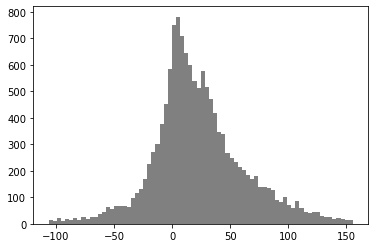

In [169]:
# SUBPLOT 2: Wind 
binEdges = np.linspace(np.nanpercentile(slope_SpdPBL_1d, 1), 
                       np.nanpercentile(slope_SpdPBL_1d, 99), 75)
plt.hist(slope_SpdPBL_1d, bins=binEdges,facecolor='grey')
plt.show()

In [173]:
# Quick peak at scatter when slope is positive vs negative...
rowPos,colPos = np.where(slope_SpdPBL_JJA>0)
sfcWindPos    = sfcWindSpd_JJA[:,rowPos,colPos]
pblhPos       = PBLH_JJA[:,rowPos,colPos]

rowNeg,colNeg = np.where(slope_SpdPBL_JJA<0)
sfcWindNeg    = sfcWindSpd_JJA[:,rowNeg,colNeg]
pblhxNeg      = PBLH_JJA[:,rowNeg,colNeg]


<ipython-input-173-b484a0dc0267>:2: RuntimeWarning: invalid value encountered in greater
  rowPos,colPos = np.where(slope_SpdPBL_JJA>0)
<ipython-input-173-b484a0dc0267>:6: RuntimeWarning: invalid value encountered in less
  rowNeg,colNeg = np.where(slope_SpdPBL_JJA<0)


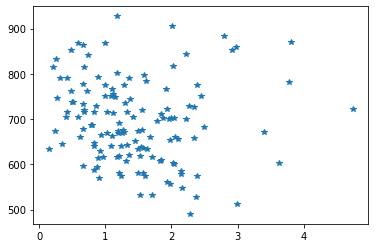

In [175]:
iPos = 90

plt.plot(sfcWindNeg[:,iPos], pblhxNeg[:,iPos],'*')


## 4. Map where correlation coefficients are greater than some threshold 

## 5. Map out regression slopes themselves (with limits based on correlation coefficient)

/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/mdfowler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
<ipython-input-61-d4d38ccf8651>:19: RuntimeWarning: invalid value encountered in less
  iNeg = np.where(slope_1d<0)[0]


25th percentile: 0.0210
75th percentile: 0.0801

Percent of gridcells < 0: 4.94 %


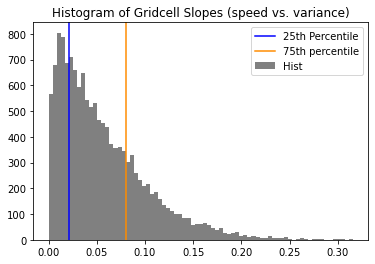

In [61]:
## ---- Definition of "high" vs. "low" slope based on percentiles of slopes ---- 

slope_1d = slope_SpdVar_JJA.reshape(len(lat)*len(lon))
plt.hist(np.abs(slope_1d), bins=75,facecolor='grey')
plt.title('Histogram of Gridcell Slopes (speed vs. variance)')

# Get 25th and 75th percentiles: 
pct25 = np.nanpercentile(np.abs(slope_1d), 25)
pct75 = np.nanpercentile(np.abs(slope_1d), 75)
print('25th percentile: %.4f' % pct25)
print('75th percentile: %.4f' % pct75)

plt.axvline(pct25,color='blue')
plt.axvline(pct75, color='darkorange')

plt.legend(['25th Percentile','75th percentile','Hist'])

# How many gridcells do have a negative slope anyway? 
iNeg = np.where(slope_1d<0)[0]
print('\nPercent of gridcells < 0: %.2f %%' % ((len(iNeg)/len(slope_1d[~np.isnan(slope_1d)]))*100) )

plt.show()

Percent of gridcells with R >=0.50: 50.153188
Percent of gridcells with R >=0.70: 31.685073


<ipython-input-68-3a8cff0a39a0>:7: RuntimeWarning: invalid value encountered in greater_equal
  i50 = np.where(r_1d>=0.5)[0]
<ipython-input-68-3a8cff0a39a0>:8: RuntimeWarning: invalid value encountered in greater_equal
  i70 = np.where(r_1d>=0.7)[0]


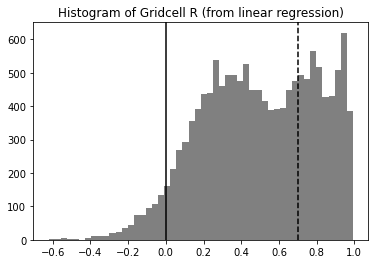

In [68]:
## ---- Plot histogram of R values (correlation coefficients )

r_1d = (rValue_SpdVar_JJA.reshape(len(lat)*len(lon)))
plt.hist(r_1d, bins=50,facecolor='grey')
plt.title('Histogram of Gridcell R (from linear regression)')

i50 = np.where(r_1d>=0.5)[0]
i70 = np.where(r_1d>=0.7)[0]
print('Percent of gridcells with R >=0.50: %f' % ((len(i50)/len(r_1d[~np.isnan(r_1d)]))*100))
print('Percent of gridcells with R >=0.70: %f' % ((len(i70)/len(r_1d[~np.isnan(r_1d)]))*100))

plt.axvline(0,color='k')
plt.axvline(0.70,color='k',linestyle='--')
plt.show()


In [71]:
## Define mask based on where corrCoef >= 0.7
maskCorrCoef = np.full([len(lat), len(lon)], np.nan)
maskCorrCoef[np.abs(rValue_SpdVar_JJA)>=0.7] = 1 


<ipython-input-71-5c1d3c57abd6>:3: RuntimeWarning: invalid value encountered in greater_equal
  maskCorrCoef[np.abs(rValue_SpdVar_JJA)>=0.7] = 1


In [63]:
## Mask for where gridcells have a high vs. a low slope: 
maskSlopes_SpdVar    = np.copy(slope_SpdVar_JJA)
maskSlopes_SpdVar[:] = np.nan
# Assign a value of 2 for gridcells with high slope 
maskSlopes_SpdVar[np.abs(slope_SpdVar_JJA)>=pct75] = 2
# Assign a value of 1 for gridcells with low slope
maskSlopes_SpdVar[np.abs(slope_SpdVar_JJA)<=pct25] = 1


<ipython-input-63-47e68cb09b2d>:5: RuntimeWarning: invalid value encountered in greater_equal
  maskSlopes_SpdVar[np.abs(slope_SpdVar_JJA)>=pct75] = 2
<ipython-input-63-47e68cb09b2d>:7: RuntimeWarning: invalid value encountered in less_equal
  maskSlopes_SpdVar[np.abs(slope_SpdVar_JJA)<=pct25] = 1


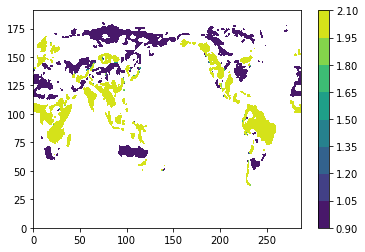

In [72]:
plt.contourf(maskSlopes_SpdVar)
plt.colorbar()

In [ ]:
# Make a mask of high vs. low slope to map 

maskHigh = np.full([len(lat), len(lon)],np.nan)
maskHigh[rowsH, colsH] = 2 
maskHigh[rowsL, colsL] = 1

# ----------- Set up figure ------------------------------------------
fig, ax1 = plt.subplots(1,1, figsize=(8, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# --------------------------------------------------------------------


# --------- Plot regions --------------------
contour_plot = ax1.pcolormesh(lon,lat, maskHigh,
                       cmap = 'PiYG_r')

ax1.set_title('High vs. Low Slope [JJA]', fontsize=14)
    
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
# Control number of ticks via 'ticker' in matplotlib 
tick_locator = ticker.MaxNLocator(nbins=1)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.set_xticklabels(['Low Slope','High Slope'])  # horizontal colorbar
# Set label and fontsize
cbar.set_label('Binary classification',fontsize=14)
cbar.ax.tick_params(labelsize=14)
# --------------------------------------

ax1.axhline(0, color='lightgray')


In [ ]:
# ------------------- Set up discrete colorbar --------------------
import matplotlib as mpl

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(-0.05, 0.35, 0.05)
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N)
# -------------------------------------------------------------------


# ----------- Set up figure ------------------------------------------
fig, ax1 = plt.subplots(1,1, figsize=(8, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
# --------------------------------------------------------------------


# --------- Plot slope --------------------
contour_plot = ax1.pcolormesh(lon,lat, slope_SpdVar_JJA*maskCorrCoef,
                       vmin = -0.05, vmax = 0.3,        
                       cmap = cmap,norm=norm)

ax1.set_title('Slope of linear regression between WindSpeed and WindVar [JJA]', fontsize=14)
    
# Add colorbar 
ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax,
                           ticks=bounds, boundaries=bounds)
# Control number of ticks via 'ticker' in matplotlib 
# tick_locator = ticker.MaxNLocator(nbins=8)
# cbar.locator = tick_locator
# cbar.update_ticks()
# Set label and fontsize
cbar.set_label('Slope of regression line',fontsize=14)
cbar.ax.tick_params(labelsize=14)
# --------------------------------------

ax1.axhline(0, color='lightgray')

# ------------- Add significance test results -----------
# for ilat in range(len(lat)):
#     for ilon in range(len(lon)):
        
#         if p_SpdVar_JJA[ilat,ilon]<0.05: 
#             ax1.plot(lon[ilon],lat[ilat],'k.', 
#                      markersize=0.15, alpha = 0.5, 
#                      transform=ccrs.PlateCarree())
# --------------------------------------------------------
